In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split

import shap

# INTRODUZIONE

Il Wine Quality è un dataset presente nella UCI machine learning repository.

Le varie features che lo compongono sono i risultati di test chimico-fisici e sensoriali effettuati su campioni di "vinho verde", un vino rosso del portogallo, volti a determinarne la qualità. 

I vini vengono infatti divisi, tramite l' attributo 'quality' in 10 classi (da 1 a 10), ciascuna delle quali rappresenta un diverso grado di eccellenza. Tanto più alto è il numero della classe di appartenza di un campione di vino e tanto maggiore è il suo valore.

# IMPORTAZIONE DATABASE REDWINE

Si inizia con l' importare il database, convertendolo da csv a pandas dataframe

In [60]:
red_wine = pd.read_csv('../data/cleaned/winequality-red.csv', sep=';')
red_wine = red_wine.apply(pd.to_numeric) # convert all columns of DataFrame
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Si procede con il controllo della distribuzione della colonna 'quality'. A tale scopo, viene generata una palette personalizzata composta da sfumature di arancione per segnalare i campioni di vino al di sotto della media, e sfumature di verde per identificare i vini di qualità superiore.

,counts,freq.
class,,
3,10,0.006254
4,53,0.033146
5,681,0.425891
6,638,0.398999
7,199,0.124453
8,18,0.011257


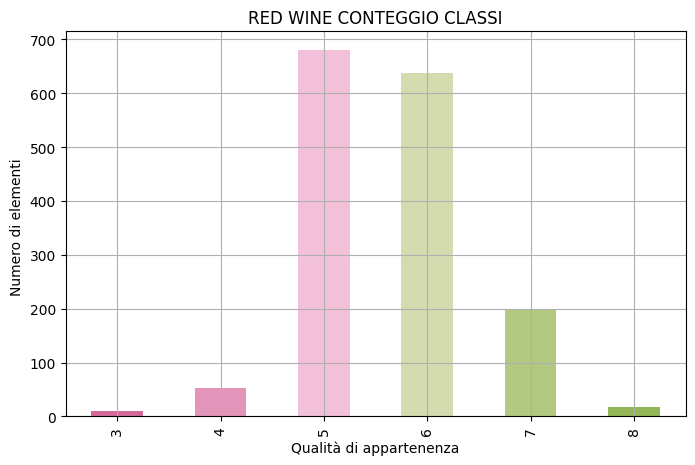

In [61]:
# Si selezionano delle tonalità di rosso e verde colorblind friendly
red_color = '#b51963'
green_color = '#5ba300'

# Tramite light_palette si creano sfumature dei colori selezionati che vengono manualmente 
# modificate per aumentarne la luminosità ed evitare colori troppo chiari
red_palette = sns.light_palette(red_color, n_colors=5, reverse=True)
red_palette = [(c[0], c[1]*0.8, c[2]*0.9) for c in red_palette]
green_palette = sns.light_palette(green_color, n_colors=5)
green_palette = [(c[0] * 0.9, c[1]*0.9, c[2] * 0.75) for c in green_palette]
custom_palette = red_palette + green_palette

# Si procede con il selezionare i valori unici della colonna 'quality' e creare un dizionario per i colori
quality_unique_values = np.unique(red_wine['quality'].values)
colors_mapping = dict(zip(np.arange(10)+1, custom_palette))

# Creazione di un dataset contenente i conteggi dei diversi livelli di qualità dei vari campioni e le loro frequenze
N = red_wine.shape[0]
class_cont_freq = pd.concat([red_wine['quality'].value_counts(), red_wine['quality'].value_counts() / N], axis=1)
class_cont_freq.columns = ['counts', 'freq.']  
class_cont_freq.index.name = 'class'
class_cont_freq.sort_values('class', inplace=True)
display(class_cont_freq)

# Un plot per mostrare la distribuzione della qualità dei vini, utilizzando la palette personalizzata
plt.figure()
class_cont_freq['counts'].plot.bar(figsize=(8, 5), color=[colors_mapping[q] for q in class_cont_freq.index])
plt.title('RED WINE CONTEGGIO CLASSI')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()
plt.show()

# PROBLEMA BINARIO

Ho diviso il problema di multiclassificazione in un problema binario accorpando le classi.

In [62]:
red_wine['quality'].replace([3, 4, 5], value=0, inplace=True)
red_wine['quality'].replace([6, 7, 8], value=1, inplace=True)

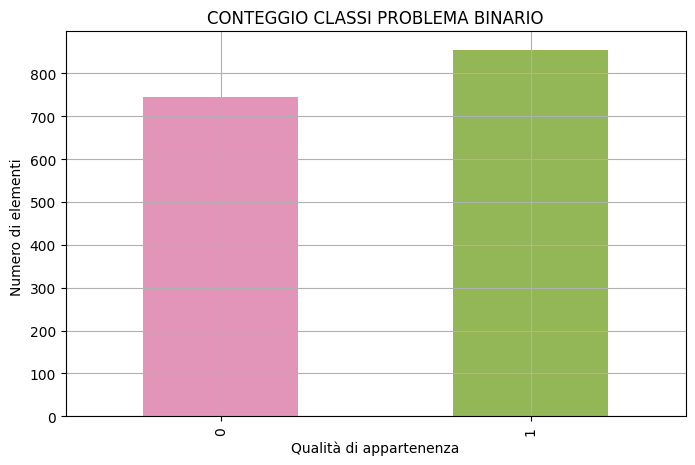

In [63]:
plt.figure()
red_wine['quality'].value_counts().sort_values().plot.bar(figsize=(8,5), color=[custom_palette[3], custom_palette[7]])
plt.title('CONTEGGIO CLASSI PROBLEMA BINARIO')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()

In [170]:
red_wine['volatile acidity'].iloc[ind_test].values

array([0.33 , 0.45 , 0.48 , 0.32 , 0.69 , 0.31 , 0.31 , 0.24 , 0.92 ,
       0.32 , 0.41 , 0.56 , 1.02 , 0.47 , 0.7  , 0.36 , 0.55 , 0.31 ,
       0.6  , 0.35 , 0.22 , 0.16 , 0.5  , 0.59 , 0.71 , 0.69 , 0.39 ,
       0.42 , 0.42 , 0.25 , 0.48 , 0.36 , 0.38 , 0.84 , 1.33 , 0.55 ,
       0.21 , 0.66 , 0.36 , 0.52 , 0.76 , 0.655, 0.31 , 0.39 , 0.54 ,
       1.02 , 0.36 , 0.34 , 0.42 , 0.41 , 0.52 , 0.62 , 0.365, 0.34 ,
       0.59 , 0.84 , 0.49 , 0.44 , 0.685, 0.725, 1.18 , 0.5  , 0.5  ,
       0.45 , 0.785, 0.43 , 0.38 , 0.62 , 0.6  , 0.6  , 0.34 , 0.36 ,
       0.29 , 0.575, 0.88 , 0.855, 0.395, 0.24 , 0.69 , 0.45 , 0.58 ,
       0.69 , 0.6  , 0.44 , 0.655, 0.68 , 0.69 , 0.53 , 0.74 , 0.42 ,
       0.49 , 0.26 , 0.6  , 0.53 , 0.58 , 0.64 , 0.43 , 0.7  , 0.86 ,
       0.49 , 0.73 , 0.835, 0.18 , 0.2  , 0.48 , 0.53 , 0.39 , 0.56 ,
       0.66 , 0.3  , 0.645, 0.51 , 0.4  , 0.24 , 0.4  , 0.28 , 0.735,
       0.6  , 0.65 , 0.4  , 0.43 , 0.6  , 0.65 , 0.5  , 0.54 , 0.38 ,
       0.39 , 0.41 ,

# PCA

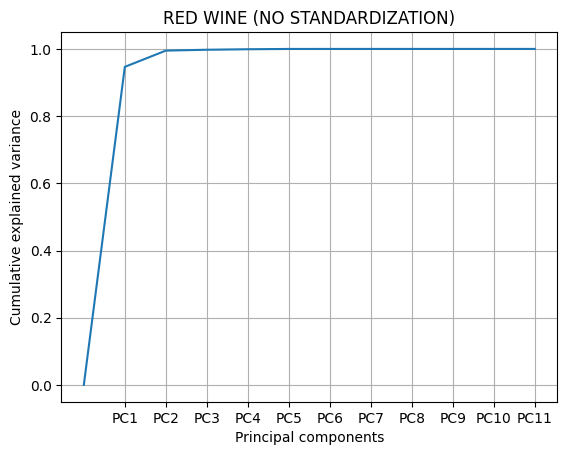

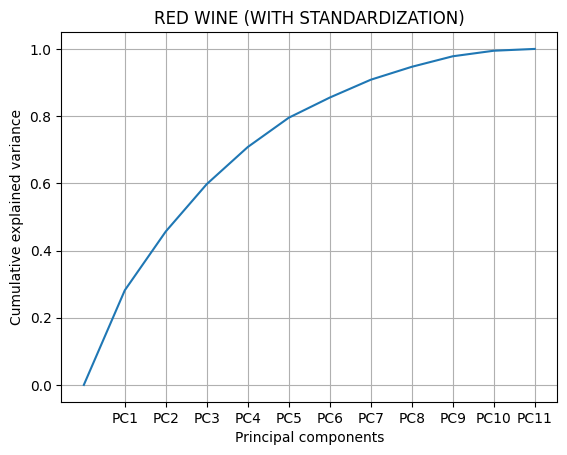

In [64]:
X_redwine = red_wine.iloc[:, :-1]  
scaler_redwine = StandardScaler().set_output(transform="pandas")
scaler_redwine.fit(X_redwine)

X_redwine_scaled = scaler_redwine.transform(X_redwine)

pca_redwine_nostd = PCA()
pca_redwine = PCA()

pca_redwine_nostd.fit(X_redwine)
pca_redwine.fit(X_redwine_scaled)

plt.figure()
plt.plot(np.insert(np.cumsum(pca_redwine_nostd.explained_variance_ratio_), 0, 0))
plt.title('RED WINE (NO STANDARDIZATION)')
plt.xticks(ticks=np.arange(1, pca_redwine_nostd.n_features_in_ + 1), 
           labels=[f'PC{i}' for i in range(1, pca_redwine_nostd.n_features_in_ + 1)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

plt.figure()
plt.plot(np.insert(np.cumsum(pca_redwine.explained_variance_ratio_), 0, 0))
plt.title('RED WINE (WITH STANDARDIZATION)')
plt.xticks(ticks=np.arange(1, pca_redwine.n_features_in_ + 1), 
           labels=[f'PC{i}' for i in range(1, pca_redwine.n_features_in_ + 1)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

In [65]:
X_redwine_scaled

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308


# SCORE GRAPH

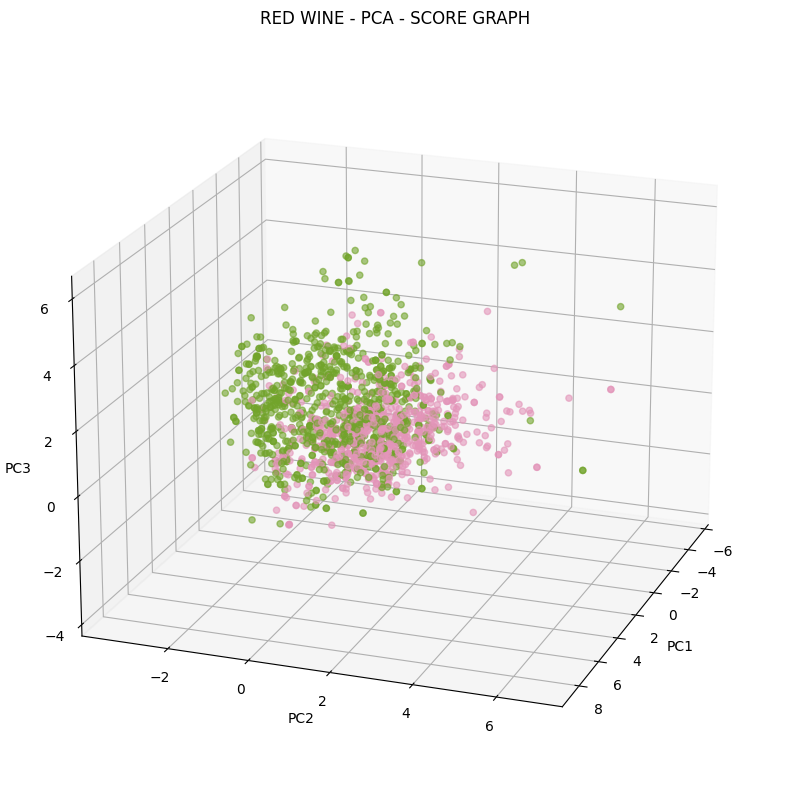

In [66]:
pca_redwine = PCA(n_components=3)

pca_redwine.fit(X_redwine_scaled)

Z3p_redwine = pca_redwine.transform(X_redwine_scaled)

colors_mapping = {0: custom_palette[3], 1: custom_palette[8]}

fig_pca_winescore = plt.figure(figsize=(25,10)) 

ax1 = fig_pca_winescore.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(Z3p_redwine[:, 0], Z3p_redwine[:, 1], Z3p_redwine[:, 2], c=[colors_mapping[val] for val in red_wine['quality']], alpha=0.6)
plt.title('RED WINE - PCA - SCORE GRAPH')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2') 
ax1.set_zlabel('PC3')
ax1.view_init(elev=20, azim=20)


Text(0, 0.5, 'PC2')

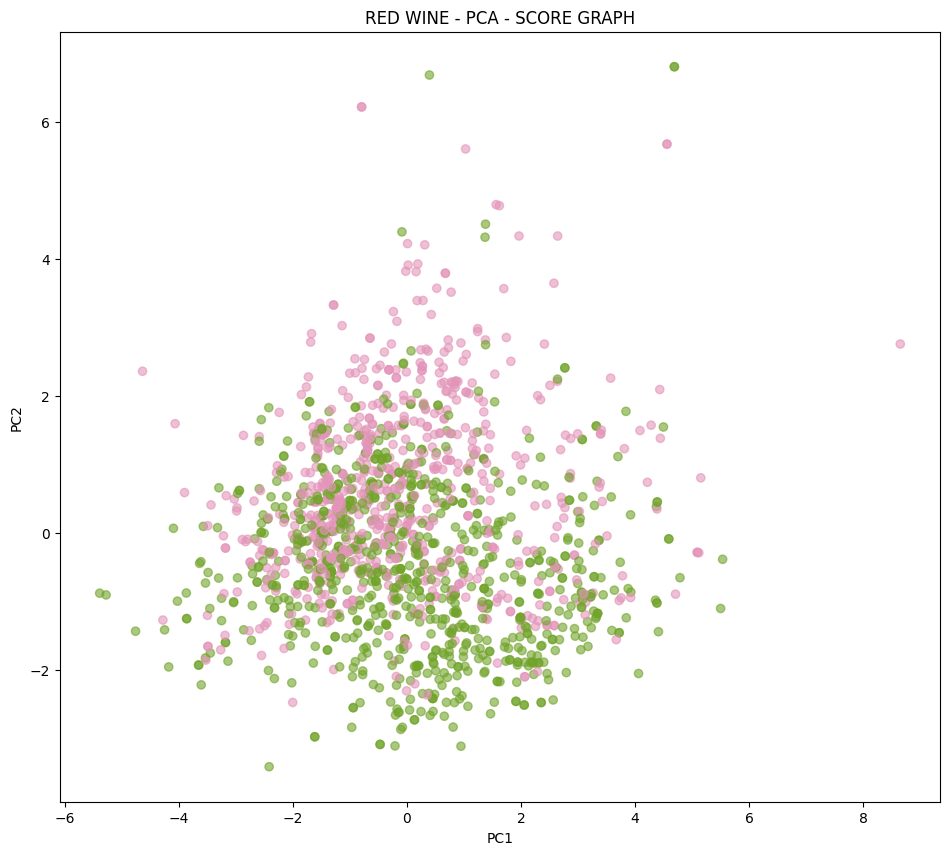

In [67]:
fig_pca_winescore = plt.figure(figsize=(25,10)) 

ax1 = fig_pca_winescore.add_subplot(1, 2, 1)
ax1.scatter(Z3p_redwine[:, 0], Z3p_redwine[:, 1], c=[colors_mapping[val] for val in red_wine['quality']], alpha=0.6)
plt.title('RED WINE - PCA - SCORE GRAPH')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2') 


# CREAZIONE TRAINING, VALIDATION E TEST SET

In [68]:
X = X_redwine
y = red_wine['quality']
y_nomi_classe = ['classe 0', 'classe 1']

random_state = 246120
test_p = 0.5
val_p = 0.4
indices = np.arange(X.shape[0])

ind_train, ind_test = train_test_split(indices, test_size=test_p, random_state=random_state, shuffle=True)
ind_train, ind_val = train_test_split(ind_train, test_size=val_p, random_state=random_state, shuffle=True)

# GRID SEARCH

In [69]:
from sklearn.preprocessing import StandardScaler
import shap

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler().set_output(transform="pandas")),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X_redwine, red_wine['quality'])



Fitting 1 folds for each of 60 candidates, totalling 60 fits


GridSearchCV(cv=<zip object at 0x00000189A42F2580>,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             param_grid={'svc__C': [0.25, 0.5, 1, 2, 4],
                         'svc__gamma': [0.18181818181818182,
                                        0.09090909090909091,
                                        0.06060606060606061],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             return_train_score=True, scoring='f1_weighted', verbose=True)

In [70]:
df_results = pd.DataFrame(svm_gs.cv_results_)

display(df_results.sort_values(['rank_test_score'], ascending=True))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
40,0.069996,0.0,0.020917,0.0,2,0.090909,rbf,"{'svc__C': 2, 'svc__gamma': 0.0909090909090909...",0.772658,0.772658,0.0,1,0.828988,0.828988,0.0
44,0.075018,0.0,0.024983,0.0,2,0.060606,rbf,"{'svc__C': 2, 'svc__gamma': 0.0606060606060606...",0.766430,0.766430,0.0,2,0.805956,0.805956,0.0
28,0.252002,0.0,0.148996,0.0,1,0.090909,rbf,"{'svc__C': 1, 'svc__gamma': 0.0909090909090909...",0.766430,0.766430,0.0,2,0.803886,0.803886,0.0
56,0.183000,0.0,0.045000,0.0,4,0.060606,rbf,"{'svc__C': 4, 'svc__gamma': 0.0606060606060606...",0.766356,0.766356,0.0,4,0.826889,0.826889,0.0
48,0.089991,0.0,0.024996,0.0,4,0.181818,rbf,"{'svc__C': 4, 'svc__gamma': 0.1818181818181818...",0.766154,0.766154,0.0,5,0.916560,0.916560,0.0
24,0.153998,0.0,0.049002,0.0,1,0.181818,rbf,"{'svc__C': 1, 'svc__gamma': 0.1818181818181818...",0.763196,0.763196,0.0,6,0.854014,0.854014,0.0
36,0.135993,0.0,0.027002,0.0,2,0.181818,rbf,"{'svc__C': 2, 'svc__gamma': 0.1818181818181818...",0.763094,0.763094,0.0,7,0.885295,0.885295,0.0
52,0.228994,0.0,0.062999,0.0,4,0.090909,rbf,"{'svc__C': 4, 'svc__gamma': 0.0909090909090909...",0.760031,0.760031,0.0,8,0.868607,0.868607,0.0
12,0.096017,0.0,0.027984,0.0,0.5,0.181818,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.18181818181818...",0.759918,0.759918,0.0,9,0.826850,0.826850,0.0
32,0.143001,0.0,0.061996,0.0,1,0.060606,rbf,"{'svc__C': 1, 'svc__gamma': 0.0606060606060606...",0.757051,0.757051,0.0,10,0.795459,0.795459,0.0


In [155]:
best_model = svm_gs.best_estimator_.fit(X_redwine.iloc[ind_train, :], y.iloc[ind_train])

y_pred_train = svm_gs.best_estimator_.predict(X.iloc[ind_train, :])
y_true_train = y.iloc[ind_train]
y_pred_val = svm_gs.best_estimator_.predict(X.iloc[ind_val, :])
y_true_val = y.iloc[ind_val]

y_pred = svm_gs.best_estimator_.predict(X.iloc[ind_test, :])
y_true = y.iloc[ind_test]

acc_train = svm_gs.best_estimator_.score(X.iloc[ind_train, :], y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X.iloc[ind_val, :], y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc = svm_gs.best_estimator_.score(X.iloc[ind_test, :], y_true)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 
                        'Precision': [prec_train, prec_val, prec], 
                        'Recall': [rec_train, rec_val, rec],
                        'F1': [f1_train, f1_val, f1]
                       },
                      index=['training', 'validation', 'test'])
cmat = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=y_nomi_classe, index=y_nomi_classe)

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)

,Accuracy,Precision,Recall,F1
training,0.828810,0.830581,0.828810,0.828988
validation,0.771875,0.784453,0.771875,0.772658
test,0.746250,0.746923,0.746250,0.746389


,classe 0,classe 1
classe 0,285,95
classe 1,108,312


,classe 0,classe 1
classe 0,0.750000,0.250000
classe 1,0.257143,0.742857


,classe 0,classe 1
classe 0,0.725191,0.233415
classe 1,0.274809,0.766585


In [72]:
scaler = best_model.named_steps['scaler']
svm_model = best_model.named_steps['svc']

X_train = scaler.transform(X.iloc[ind_train])
X_test = scaler.transform(X.iloc[ind_test])

background_data = shap.sample(X_train, nsamples=100, random_state=246120)
base_values = np.full(background_data.shape[0], svm_model.predict(background_data).mean())

Permutation_explainer = shap.explainers.Permutation(svm_model.predict, background_data, seed=246120)
shap_values_Perm = Permutation_explainer.shap_values(X_test)

shap_explanation_Perm = shap.Explanation(shap_values_Perm, base_values, X_test.values, feature_names=X_test.columns)


PermutationExplainer explainer: 801it [11:17,  1.16it/s]                         


La maggior parte dei plot della libreria SHAP ha bisogno di un Explanation Object, ovvero un array di 3 arrays: \
&emsp; ■ .values: n x p array, contenente i valori di SHAP \
&emsp; ■ .base_values: n x 1 array, contenente la ripetizione della media delle previsioni del modello sui campioni del background \
&emsp; ■ .data: n x p array, contenente i valori della parte di dataset che si sta cercando di spiegare \
Dopo aver definito un explainer ci sono due modi per creare un Explanation Object:
&emsp; ■ METODO DIRETTO: si chiama direttamente l'explainer su ciò che si vuole spiegare: Permutation_explainer.shap_values(X_test): 
&emsp; ■ METODO INDIRETTO: 

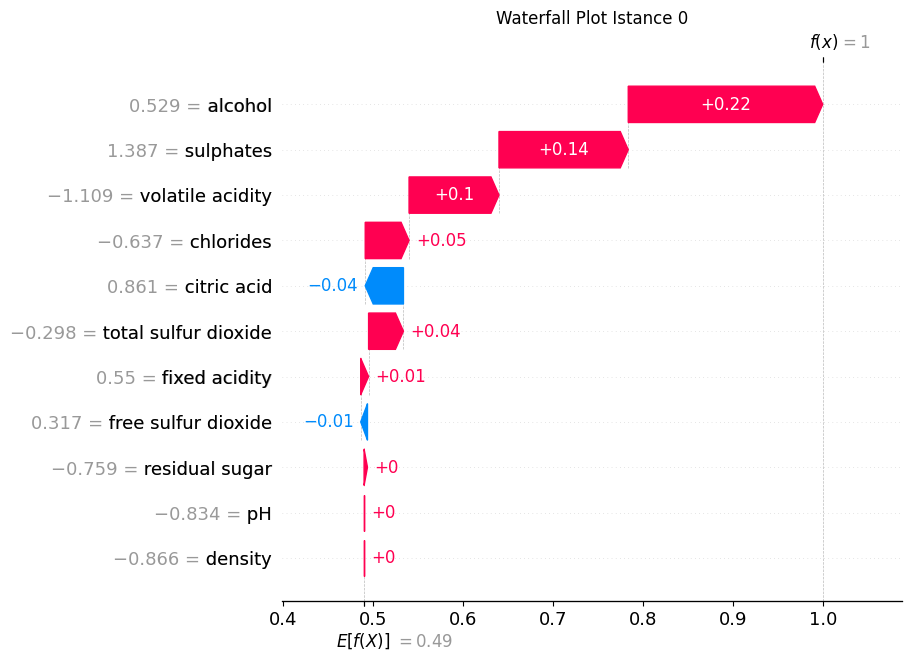

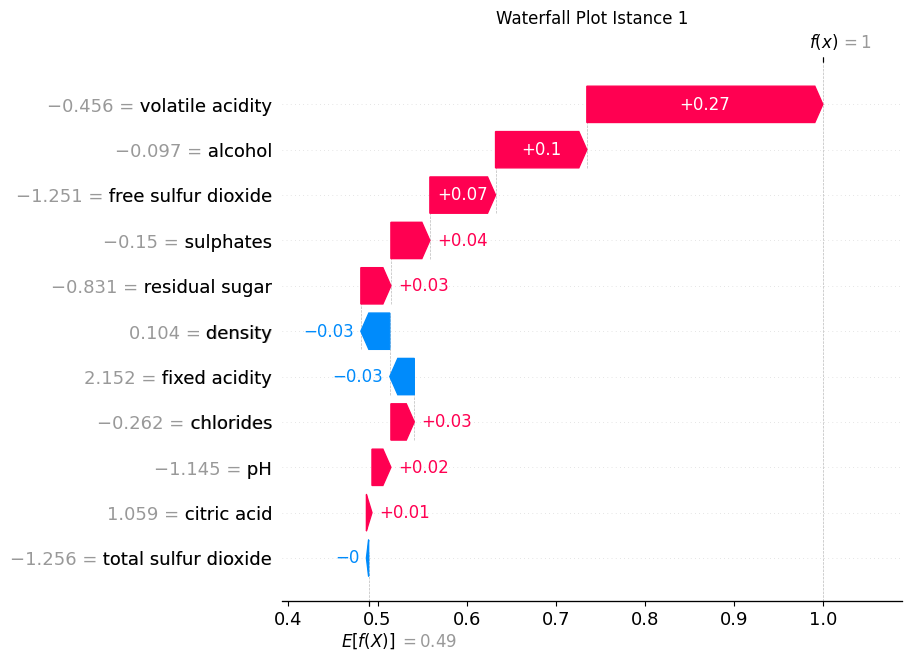

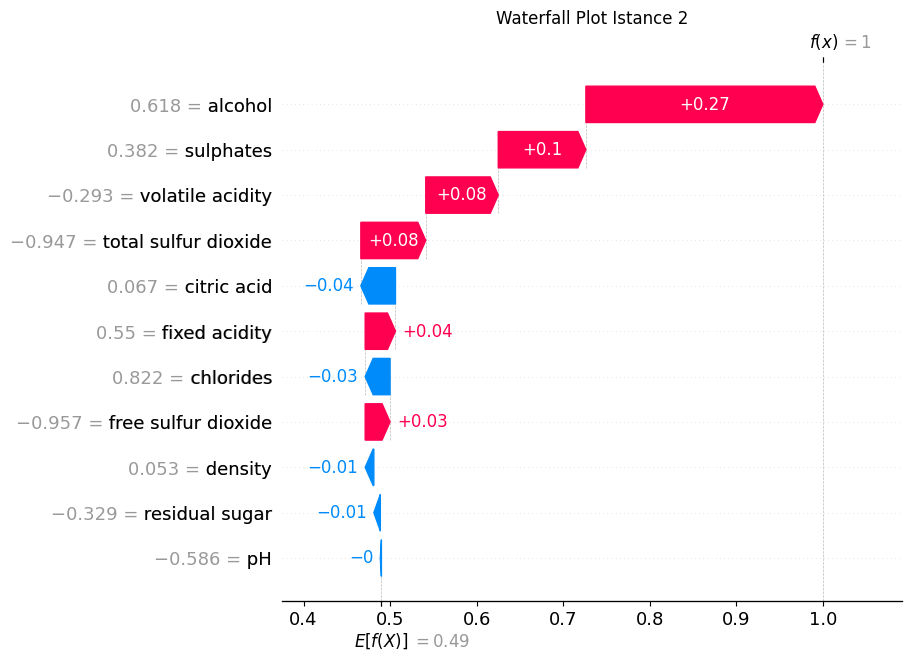

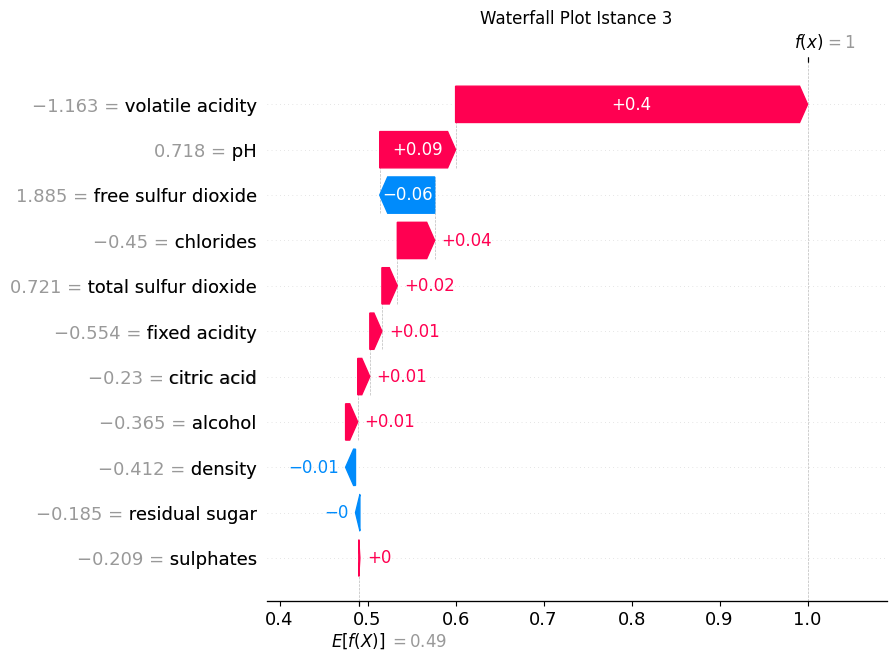

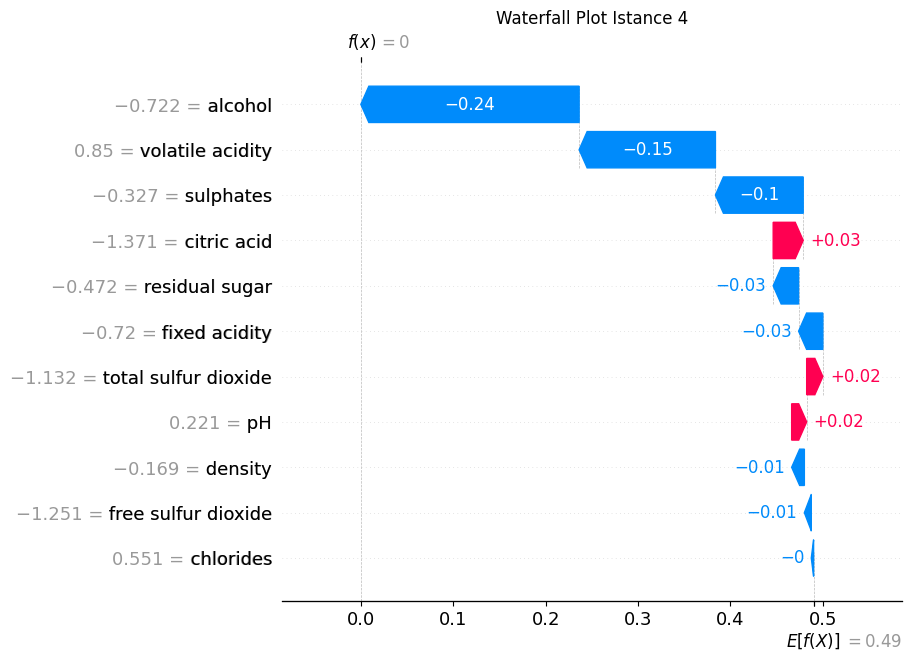

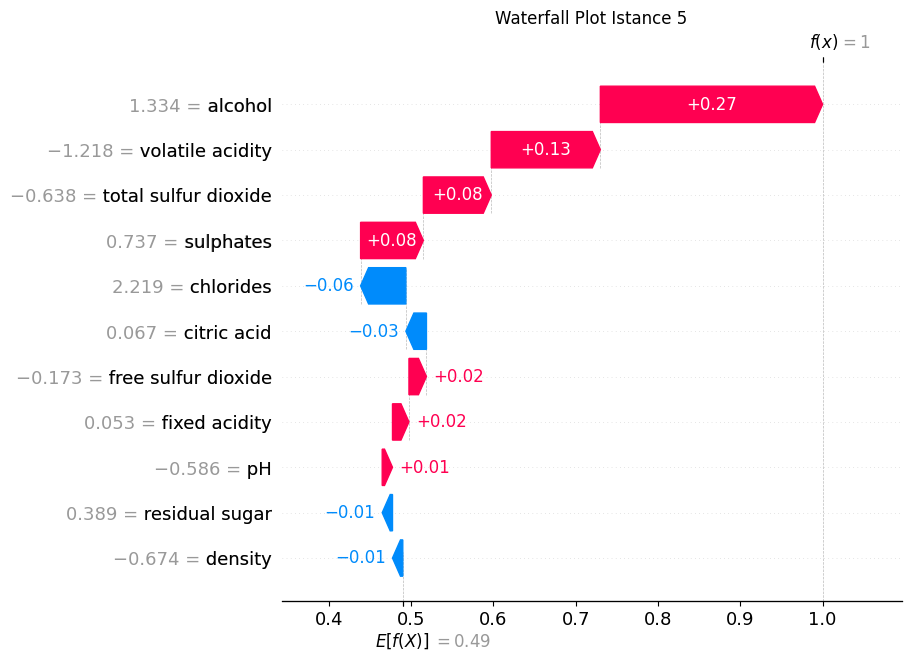

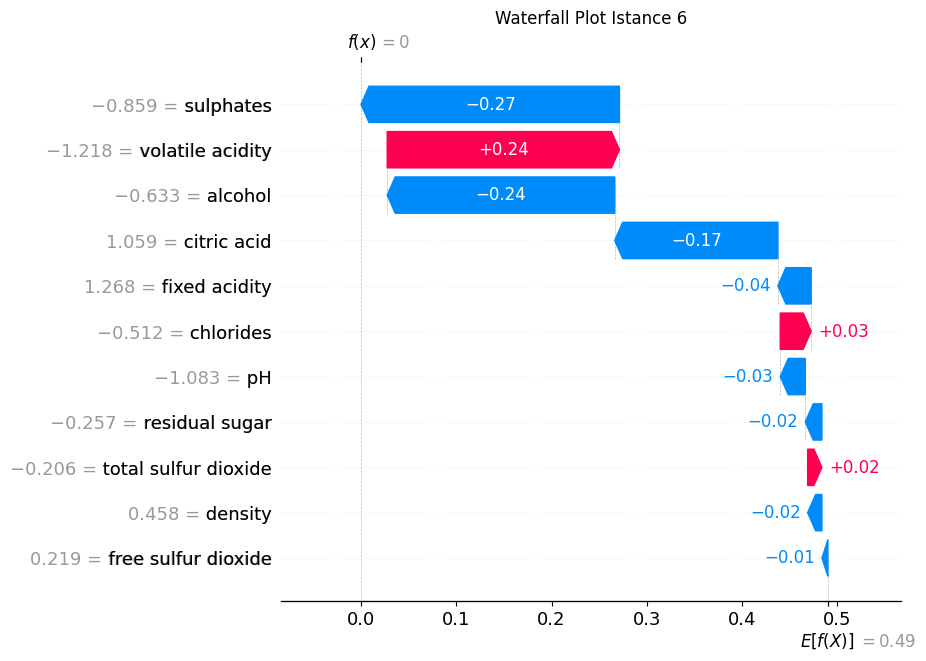

In [173]:
for i in range(7):
    fig = plt.figure()
    shap.plots.waterfall(shap_explanation_Perm[i], max_display=X_test.shape[1], show=False)
    plt.title(f'Waterfall Plot Istance {i}')


plt.show()
plt.close()


In [174]:
shap.initjs()
shap.plots.force(shap_explanation_Perm[0])

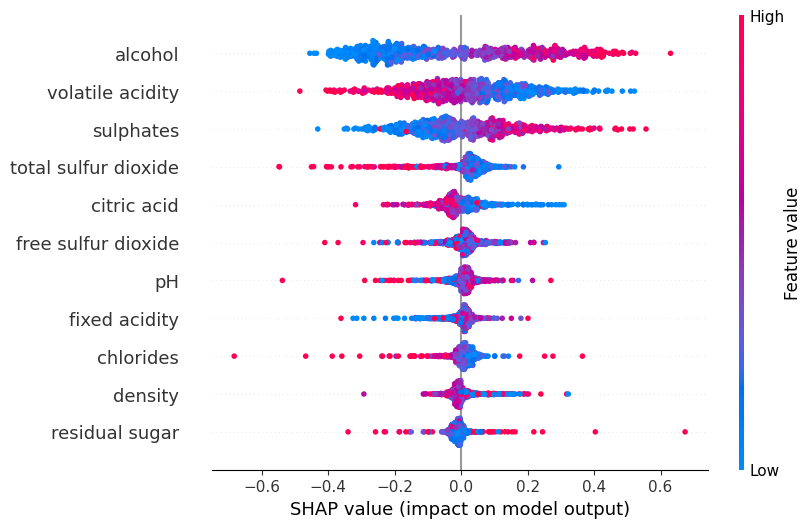

In [51]:
shap.plots.beeswarm(shap_explanation_Perm, max_display=X_test.shape[1])

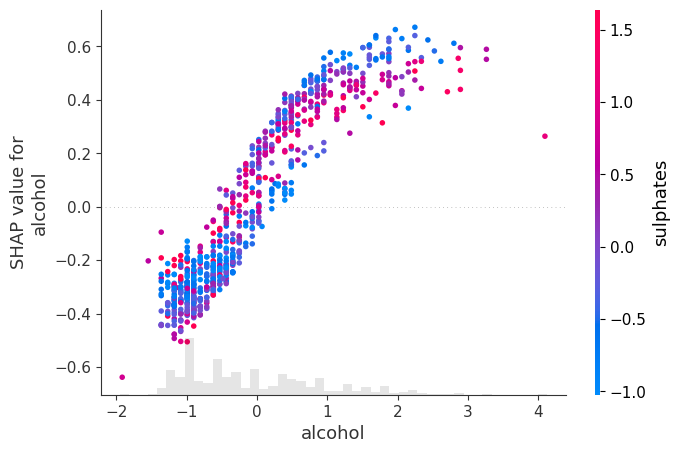

In [103]:
shap.plots.scatter(shap_explanation_Perm[:, 'alcohol'], color=shap_explanation_Perm)


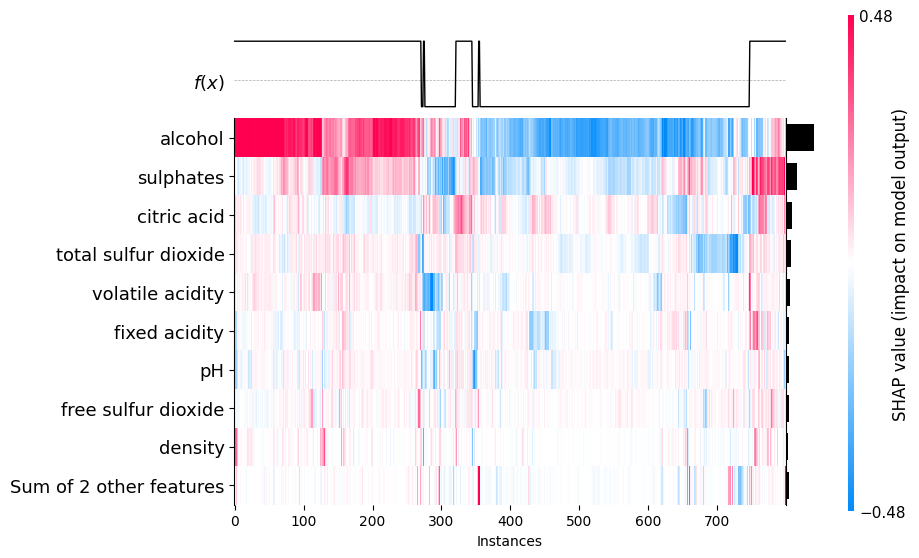

In [104]:
shap.plots.heatmap(shap_explanation_Perm)


In [109]:
shap.plots.force(shap_explanation_Perm[0:20])

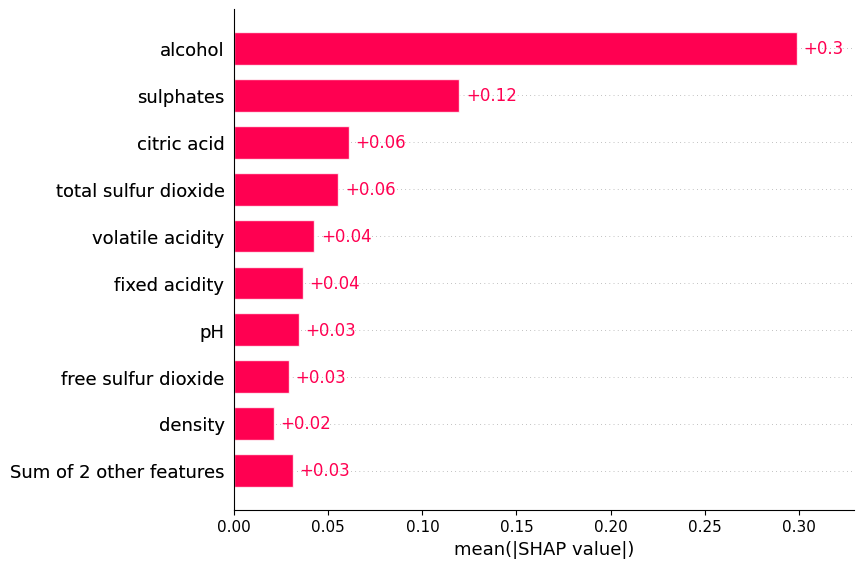

In [110]:
shap.plots.bar(shap_explanation_Perm)

In [ ]:
# define a partition masker that uses our clustering
clustering = shap.utils.hclust(
    sample, y.loc[sample.index]
)
masker = shap.maskers.Partition(sample, clustering=clustering)
explainer = shap.Explainer(svm_model.predict, masker)
sample_test = shap.sample(X_test, 50)

shap_values_partition = explainer(sample_test)

In [ ]:
shap_explanation_2 = shap.Explanation(shap_values_partition, base_values=base_value, data=sample_test, feature_names=sample_test.columns)

In [ ]:
clustering = shap.utils.hclust(
    X_train, y.iloc[ind_train]
)  # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_explanation, clustering=clustering, clustering_cutoff=0.5)

In [ ]:
shap.plots.bar(shap_explanation_2, clustering=clustering, clustering_cutoff=0.5)


In [ ]:
X_feature_reduction = X_redwine.drop(['fixed acidity'], axis=1)
svm_gs.best_estimator_.fit(X_feature_reduction.iloc[ind_train, :], y.iloc[ind_train])
y_pred_train = svm_gs.best_estimator_.predict(X_feature_reduction.iloc[ind_train, :])
y_true_train = y.iloc[ind_train]
y_pred_val = svm_gs.best_estimator_.predict(X_feature_reduction.iloc[ind_val, :])
y_true_val = y.iloc[ind_val]

y_pred = svm_gs.best_estimator_.predict(X_feature_reduction.iloc[ind_test, :])
y_true = y[ind_test]

acc_train = svm_gs.best_estimator_.score(X_feature_reduction.iloc[ind_train, :], y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X_feature_reduction.iloc[ind_val, :], y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc = svm_gs.best_estimator_.score(X_feature_reduction.iloc[ind_test, :], y_true)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 
                        'Precision': [prec_train, prec_val, prec], 
                        'Recall': [rec_train, rec_val, rec],
                        'F1': [f1_train, f1_val, f1]
                       },
                      index=['training', 'validation', 'test'])
cmat = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=y_nomi_classe, index=y_nomi_classe)

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)